In [59]:
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

In [76]:
# Normalize between 0 and 1, then multiply by 255
def normalize_img(image, dtype=np.uint8):
    image = image.astype(float)
    image -= np.amin(image.astype(float))
    image /= np.amax(image)
    image *= 255
    return image.astype(dtype)

In [82]:
def threshold_slice(input_slice, window_size=20, step_size=10, global_thresh=False):
    
    input_slice = normalize_img(input_slice)

    # Ensure the image stack is in the correct format (8-bit)
    if input_slice.dtype != np.uint8:
        input_slice = input_slice.astype(np.uint8)

    # Create a blank image to store results
    output_slice = np.zeros_like(input_slice)

    # Dimensions of the image
    rows, cols = input_slice.shape

    # Loop over the image with the given step size
    for row in range(0, rows - window_size + 1, step_size):
        for col in range(0, cols - window_size + 1, step_size):
            # Extract the window
            window = input_slice[row:row + window_size, col:col + window_size]

            # Apply local thresholding
            if global_thresh:
                _, window_thresh = cv2.threshold(window, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            else:
                local_thresh = np.mean(window) - np.std(window)
                _, window_thresh = cv2.threshold(window, local_thresh, 255, cv2.THRESH_BINARY)
            
            # Place the thresholded window back into the segmented image
            output_slice[row:row + window_size, col:col + window_size] = np.maximum(output_slice[row:row + window_size, col:col + window_size], window_thresh)

    return output_slice


In [62]:
def threshold_stack(input_stack):

    output_stack = np.zeros_like(input_stack)

    for z in range(input_stack.shape[0]):
        slice = input_stack[z,:,:]
        output_stack[z,:,:] = threshold_slice(slice)

    return output_stack

In [63]:
# Load image stack
stack = io.imread('stacks/exp240202_01_E.tif')

In [64]:
input_stack = stack[0,:,:,:]

In [83]:
# Parameters
block_size = 30  # Change according to your image dimensions
step_size = 10  # Overlapping block step

# Process the image stack
result = threshold_stack(input_stack)

In [101]:
test = normalize_img(input_stack[16,:,:])
print(f"{np.amax(test)}")
print(f"{np.amin(test)}")
print(f"{np.mean(test)}")

255
0
7.751999114486201


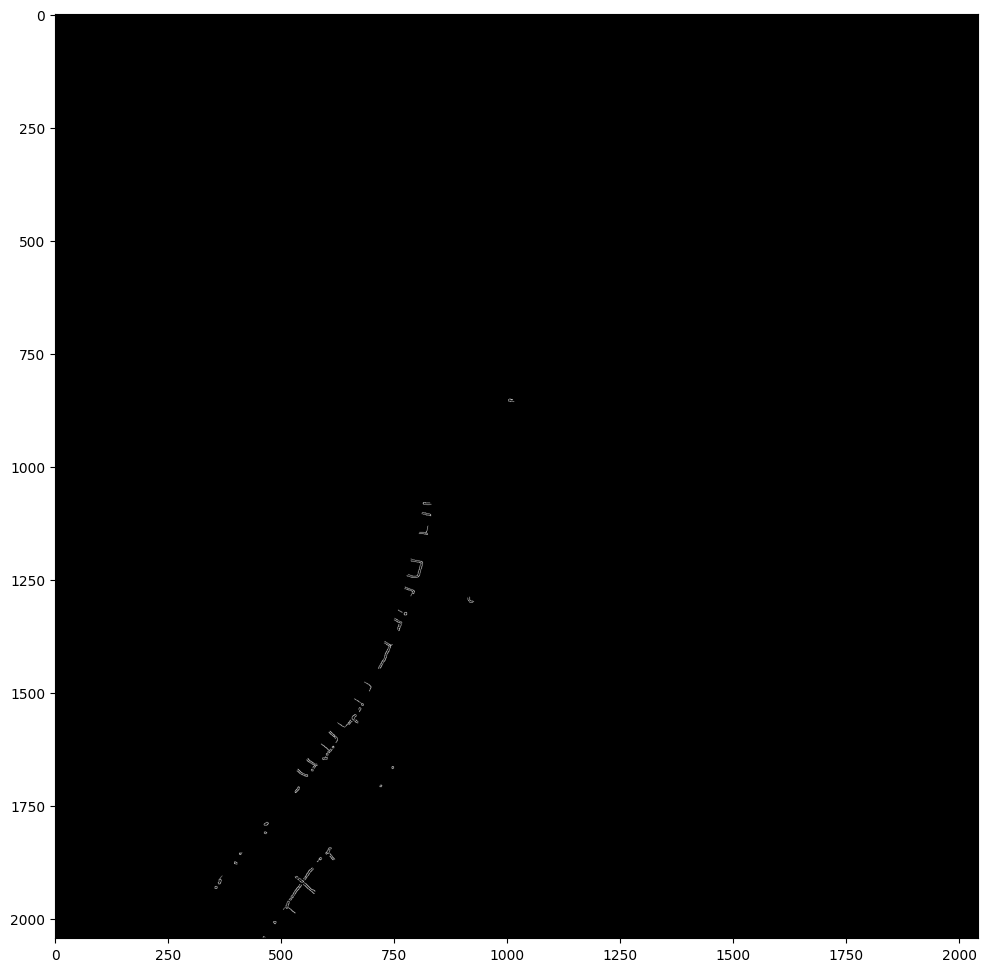

In [109]:
from skimage import io
from skimage.feature import canny
from skimage.color import rgb2gray

# Load an image

# Apply Canny edge detection
# sigma is the standard deviation of the Gaussian filter, adjust as needed for your image
edges = canny(test, sigma=1)  

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(edges, cmap='gray')

In [79]:
_, slice_thresh = cv2.threshold(normalize_img(input_stack[16,:,:]), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

Text(0.5, 1.0, 'Sliding Window MIP Slice 32')

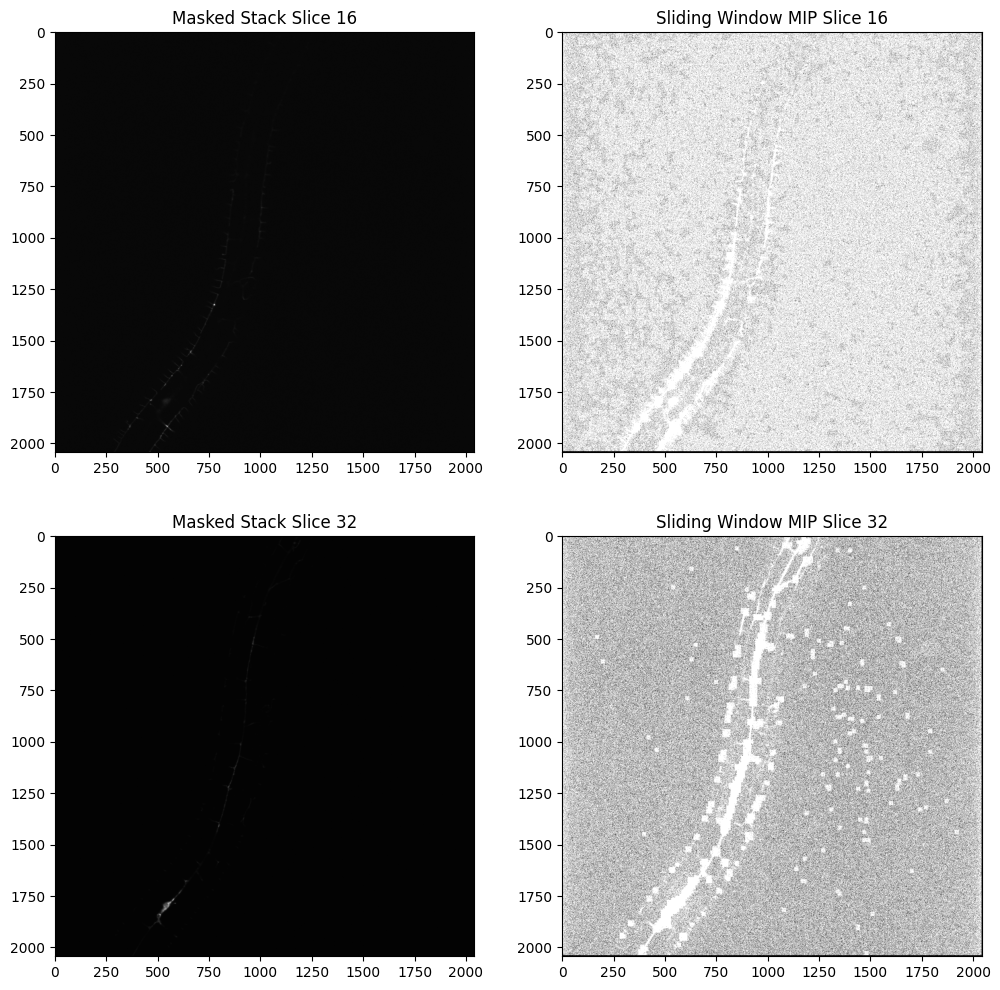

In [84]:
# Visualize some MIP outputs
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

preview_slices = [16,32]

# Full stack MIP
mip_image = input_stack[preview_slices[0],:,:]
# Sliding window MIP slice 1
mip_slice_1 = result[preview_slices[0],:,:]
# Sliding window MIP slice 1
mip_slice_2 = input_stack[preview_slices[1],:,:]
# Sliding window MIP slice 1
mip_slice_3 = result[preview_slices[1],:,:]

axs[0, 0].imshow(mip_image, cmap='gray')
axs[0, 0].set_title(f'Masked Stack Slice {preview_slices[0]}')

axs[0, 1].imshow(mip_slice_1, cmap='gray')
axs[0, 1].set_title(f'Sliding Window MIP Slice {preview_slices[0]}')

axs[1, 0].imshow(mip_slice_2, cmap='gray')
axs[1, 0].set_title(f'Masked Stack Slice {preview_slices[1]}')

axs[1, 1].imshow(mip_slice_3, cmap='gray')
axs[1, 1].set_title(f'Sliding Window MIP Slice {preview_slices[1]}')
